# Flight Delay Prediction
#### CHAPTER 03: _Interpretation Challenges_
##### From **Interpretable Machine Learning with Python 2nd Edition)** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

The following cell checks if the libraries required by this chapter are installed and installs them **ONLY** if they aren't. Please note that this step is not necessary if you have already installed ALL libraries required by the entire book with the [setup.py](../setup.py) script for the entire book. Instructions to do this are in the [README.md](../README.md).

In [ ]:
!python chapter_setup.py

### Loading the Libraries

In [1]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,\
                                  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes,\
                    neighbors, ensemble, neural_network, svm

from rulefit import RuleFit
import statsmodels.api as sm

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

import tensorflow as tf
from gaminet import GAMINet
from gaminet.utils import plot_trajectory, plot_regularization,\
                    local_visualize, global_visualize_density,\
                    feature_importance_visualize 

import matplotlib.pyplot as plt

### Understanding and Preparing the Data

In [2]:
aad18_df = mldatasets.load("aa-domestic-delays-2018")

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter3/data/aa-domestic-delays-2018.csv.zip
/Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter3/data/aa-domestic-delays-2018.csv.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter3/data/aa-domestic-delays-2018.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter3/data/aa-domestic-delays-2018.csv folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter3/data/aa-domestic-delays-2018.csv/aa-domestic-delays-2018.csv


In [3]:
print(aad18_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DEP_TIME          899527 non-null  int64  
 5   DEP_TIME              899527 non-null  float64
 6   DEP_DELAY             899527 non-null  float64
 7   DEP_AFPH              899527 non-null  float64
 8   DEP_RFPH              899527 non-null  float64
 9   TAXI_OUT              899527 non-null  float64
 10  WHEELS_OFF            899527 non-null  float64
 11  CRS_ELAPSED_TIME      899527 non-null  float64
 12  PCT_ELAPSED_TIME      899527 non-null  float64
 13  DISTANCE              899527 non-null  float64
 14  CRS_ARR_TIME          899527 non-null  int64  
 15  

#### Data Preparation

In [4]:
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])

In [5]:
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek

In [6]:
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

In [7]:
#Create list with 10 hubs
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL',\
        'PHX', 'DCA']

#Boolean series for if ORIGIN or DEST are hubs
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)

#Use boolean series to set ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1

#Delete columns with codes
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

In [8]:
aad18_df.loc[aad18_df['ARR_DELAY'] > 15, ['ARR_DELAY','CARRIER_DELAY']].head(10)

,ARR_DELAY,CARRIER_DELAY
8,168.0,136.0
16,20.0,5.0
18,242.0,242.0
19,62.0,62.0
22,19.0,19.0
26,26.0,0.0
29,77.0,77.0
32,19.0,19.0
33,18.0,1.0
40,36.0,16.0


In [9]:
aad18_df = aad18_df.drop(['ARR_DELAY'], axis=1)

In [10]:
rand = 9
np.random.seed(rand)

y = aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

In [11]:
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
ORIGIN_HUB             0.015334
DEST_HUB               0.013932
DISTANCE               0.010680
DEP_MONTH              0.009728
CRS_ELAPSED_TIME       0.008801
DEP_DOW                0.007043
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
SECURITY_DELAY         0.000460
Name: CARRIER_DELAY, dtype: float64

## Reviewing Traditional Model Interpretation Methods

### Predicting Minutes Delayed with Various Regression Methods

#### Training and Evaluating the Regression Models

In [12]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()}, 
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
        #Trees  
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #RuleFit
        'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)}, 
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)}, 
        #Neural Networks
        'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500, 
                                                   early_stopping=True, random_state=rand)}
    }

In [13]:
%%time
for model_name in reg_models.keys():
    print(model_name)
    if model_name != 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
        y_train_pred = fitted_model.predict(X_train)
        y_test_pred = fitted_model.predict(X_test)
    else:
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
        y_train_pred = fitted_model.predict(X_train.values)
        y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

linear
linear_poly
linear_interact
ridge
decision_tree
rulefit
knn
random_forest
mlp


X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with featur

CPU times: user 4h 35min 28s, sys: 1h 52min 14s, total: 6h 27min 42s
Wall time: 4h 19min 9s


In [14]:
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.format({'RMSE_train':\
                '{:.2f}', 'RMSE_test': '{:.2f}', 'R2_test': '{:.3f}'}).\
    background_gradient(cmap='viridis_r', low=0.1, high=1, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.1, high=1, subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
mlp,3.24,3.31,0.987
random_forest,5.14,6.09,0.956
linear_poly,6.21,6.34,0.952
linear_interact,6.45,6.56,0.949
decision_tree,6.54,7.46,0.934
linear,7.82,7.88,0.926
ridge,7.85,7.91,0.926
knn,7.36,9.26,0.898
rulefit,9.17,9.31,0.897


### Classifying Flights as Delayed or Not Delayed with Various Classification Methods

#### Training and Evaluating the Classification Models

In [15]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression()}, 
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},  
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7)}, 
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11,\
                                                                 class_weight='balanced', random_state=rand)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

In [16]:
print(y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0])

0.061283264255549


In [17]:
%%time
for model_name in class_models.keys():
    print(model_name)
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train_class)
    y_train_pred = fitted_model.predict(X_train)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test) 
    else:
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = np.nan
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

logistic


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


ridge
decision_tree
knn
naive_bayes
gradient_boosting
random_forest
mlp
CPU times: user 4h 27min 54s, sys: 1h 51min 51s, total: 6h 19min 46s
Wall time: 4h 18min 40s


In [18]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    format(dict(zip(class_metrics.columns, ['{:.3f}']*7))).\
    background_gradient(cmap='plasma', low=1, high=0.1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.1, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
mlp,0.998,0.999,0.987,0.989,1.000,0.988,0.987
gradient_boosting,0.992,0.992,0.893,0.894,0.999,0.929,0.926
random_forest,0.941,0.940,1.000,0.992,0.995,0.670,0.685
decision_tree,0.983,0.983,0.857,0.852,0.995,0.859,0.850
logistic,0.975,0.975,0.687,0.686,0.963,0.769,0.762
knn,0.973,0.965,0.681,0.608,0.948,0.681,0.668
naive_bayes,0.925,0.926,0.279,0.274,0.812,0.311,0.275
ridge,0.890,0.891,0.777,0.778,nan,0.467,0.464


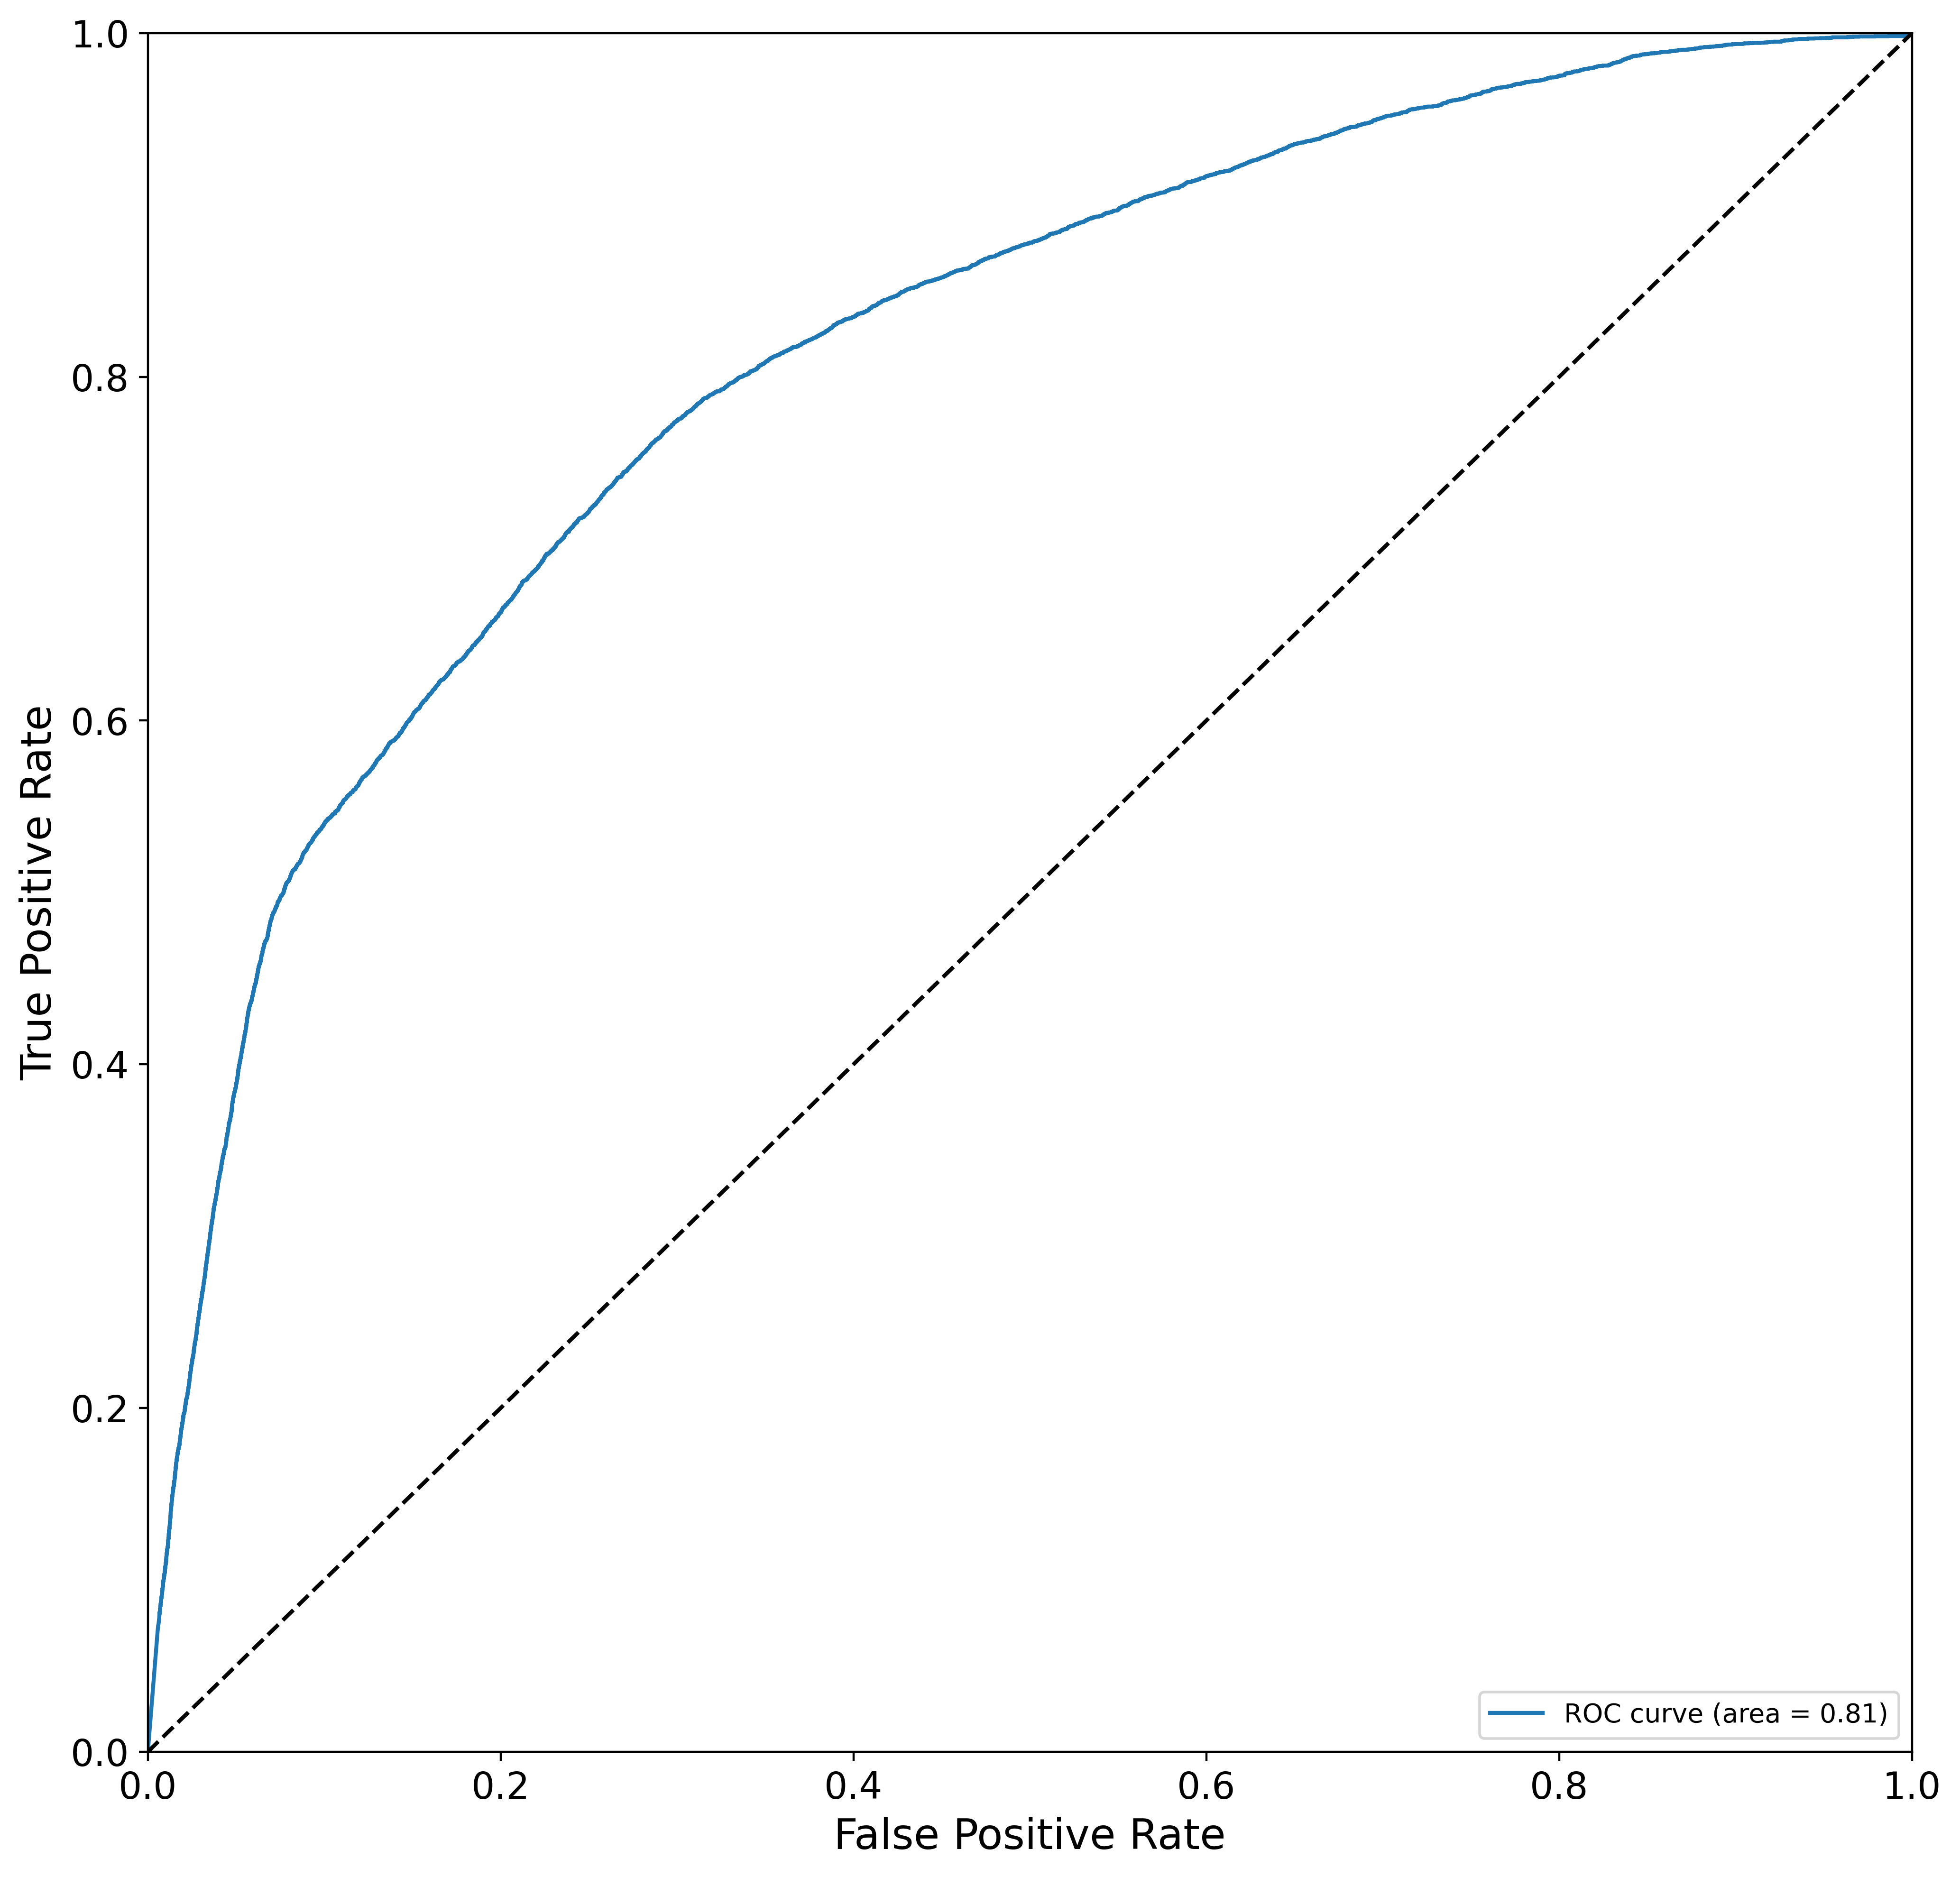

In [19]:
plt.figure(figsize = (12,12), dpi=400)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
fpr, tpr, _ = metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")
plt.show()

## Studying Intrinsically interpretable (White-box) models

### Generalized Linear Models (GLMs)

#### Linear Regression

In [20]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.54984539e-03 -5.25067742e-03  8.94125541e-01 -1.52961053e-02
 -4.69623002e-01  1.25277815e-01 -6.46744472e-04 -1.26240049e-02
  4.50112895e+01  6.76385421e-04 -3.69920254e-04  5.47855860e-04
  3.73866548e-01 -9.06364154e-01 -6.74052666e-01 -9.17411191e-01
 -9.29843952e-01 -3.96621856e-02 -1.79666480e-02 -1.02912927e+00
 -3.94934854e-01]
intercept:	-37.86177932752646


In [21]:
print('ŷ = %0.2f + %0.4fX₁ + %0.4fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = -37.86 + 0.0045X₁ + -0.0053X₂ + 0.894X₃ + ...


In [22]:
pd.DataFrame({'feature':X_train.columns.tolist(),\
                        'coef': coefs_lm.tolist()})

,feature,coef
0,CRS_DEP_TIME,0.004550
1,DEP_TIME,-0.005251
2,DEP_DELAY,0.894126
3,DEP_AFPH,-0.015296
4,DEP_RFPH,-0.469623
5,TAXI_OUT,0.125278
6,WHEELS_OFF,-0.000647
7,CRS_ELAPSED_TIME,-0.012624
8,PCT_ELAPSED_TIME,45.011289
9,DISTANCE,0.000676


In [23]:
linreg_mdl = sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
print(linreg_mdl.summary())

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


                            OLS Regression Results                            
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 4.251e+05
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        03:31:18   Log-Likelihood:            -2.6574e+06
No. Observations:              764597   AIC:                         5.315e+06
Df Residuals:                  764575   BIC:                         5.315e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -37.8618    

In [24]:
summary_df = linreg_mdl.summary2().tables[1]
summary_df = summary_df.drop(['const']).reset_index().rename(columns={'index':'feature'})
summary_df['t_abs'] = abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.\
    format(dict(zip(summary_df.columns[1:], ['{:.4f}']*7))).\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|','t_abs'])

,feature,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
2,DEP_DELAY,0.8941,0.0003,2951.0560,0.0000,0.8935,0.8947,2951.0560
16,LATE_AIRCRAFT_DELAY,-0.9298,0.0005,-1827.0181,0.0000,-0.9308,-0.9288,1827.0181
13,WEATHER_DELAY,-0.9064,0.0009,-995.3664,0.0000,-0.9081,-0.9046,995.3664
14,NAS_DELAY,-0.6741,0.0008,-829.1287,0.0000,-0.6756,-0.6725,829.1287
8,PCT_ELAPSED_TIME,45.0113,0.1172,384.0726,0.0000,44.7816,45.2410,384.0726
15,SECURITY_DELAY,-0.9174,0.0055,-167.8571,0.0000,-0.9281,-0.9067,167.8571
5,TAXI_OUT,0.1253,0.0012,104.1196,0.0000,0.1229,0.1276,104.1196
0,CRS_DEP_TIME,0.0045,0.0001,62.8717,0.0000,0.0044,0.0047,62.8717
1,DEP_TIME,-0.0053,0.0001,-57.1159,0.0000,-0.0054,-0.0051,57.1159
3,DEP_AFPH,-0.0153,0.0003,-47.7245,0.0000,-0.0159,-0.0147,47.7245


#### Ridge Regression

In [25]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef_linear': coefs_lm,\
                        'coef_ridge': coefs_ridge})
coef_ridge_df['coef_regularization'] = coef_ridge_df['coef_linear'] - coef_ridge_df['coef_ridge']
coef_ridge_df.style.\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['coef_regularization'])

,feature,coef_linear,coef_ridge,coef_regularization
0,CRS_DEP_TIME,0.004550,0.004431,0.000119
1,DEP_TIME,-0.005251,-0.004859,-0.000391
2,DEP_DELAY,0.894126,0.892296,0.001830
3,DEP_AFPH,-0.015296,-0.015152,-0.000144
4,DEP_RFPH,-0.469623,-0.469627,0.000004
5,TAXI_OUT,0.125278,0.125145,0.000133
6,WHEELS_OFF,-0.000647,0.000009,-0.000655
7,CRS_ELAPSED_TIME,-0.012624,-0.012487,-0.000137
8,PCT_ELAPSED_TIME,45.011289,45.011278,0.000012
9,DISTANCE,0.000676,0.001463,-0.000786


In [26]:
num_alphas = 100
alphas = np.logspace(0, 13, num_alphas)
alphas_coefs = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
    alphas_coefs.append(np.concatenate((ridge.coef_[:8],ridge.coef_[9:])))

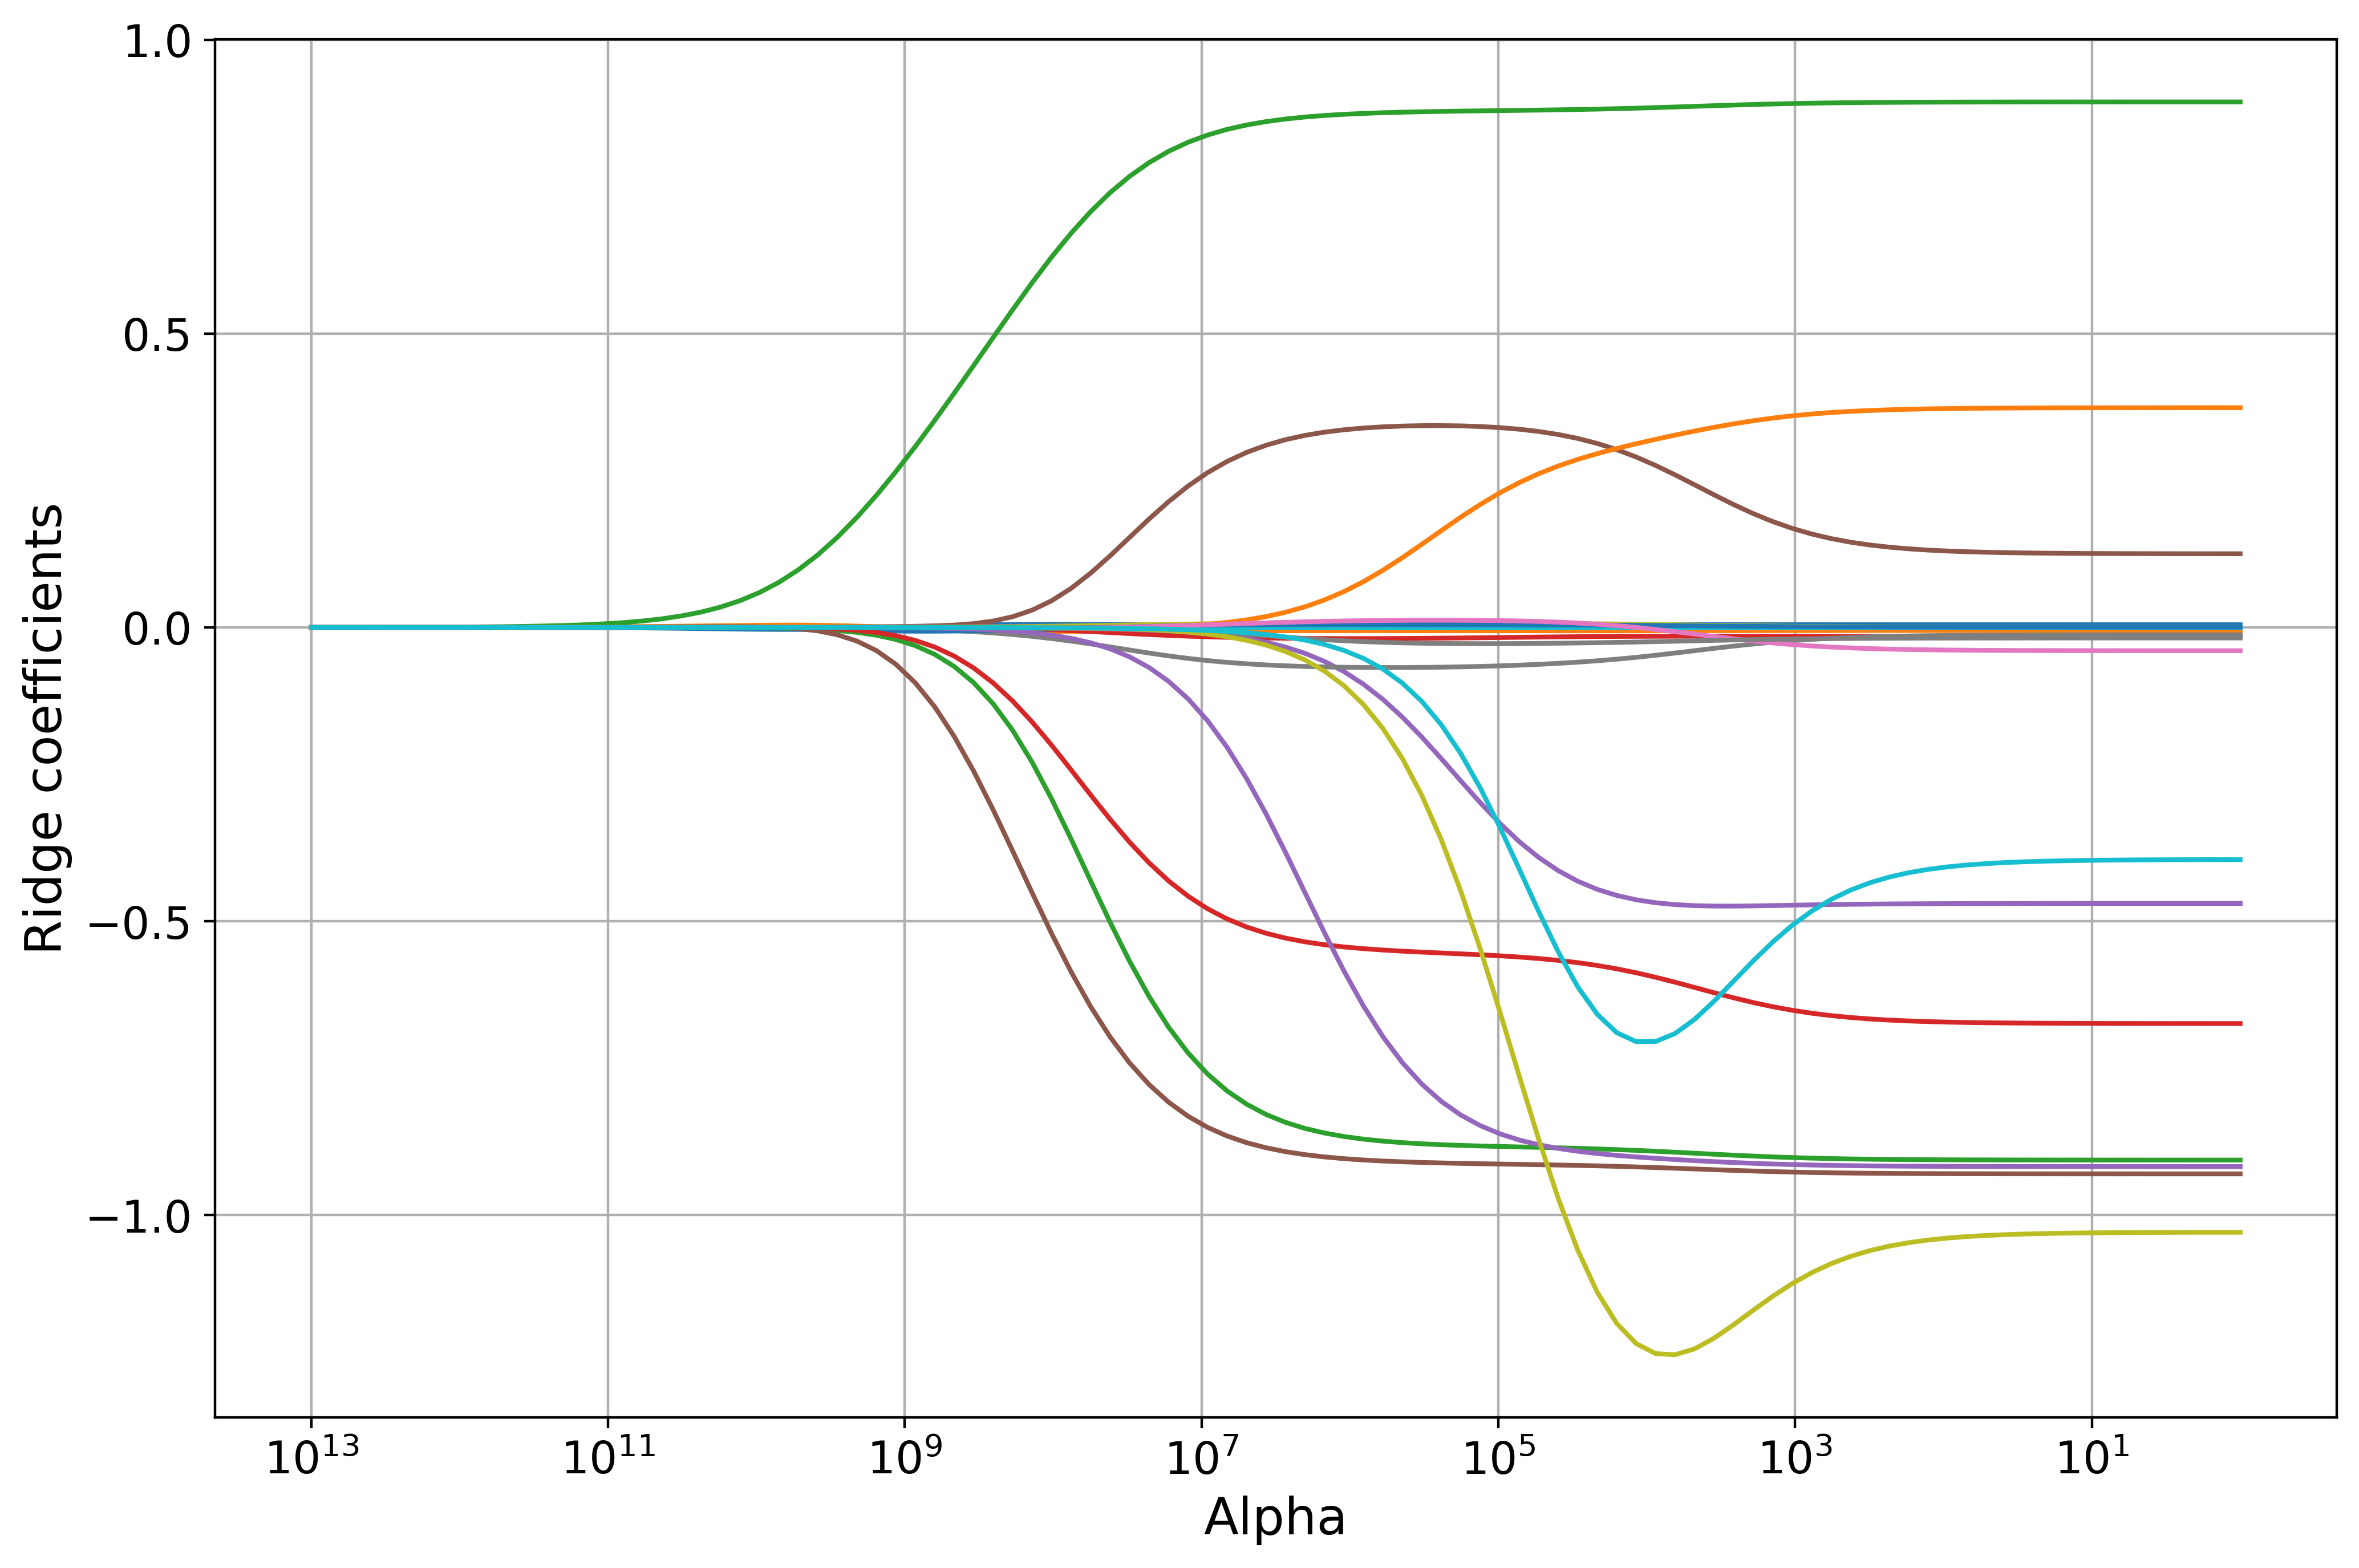

In [27]:
plt.figure(figsize = (12,8), dpi=400)
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 16)
plt.ylabel('Ridge coefficients', fontsize = 16)
plt.grid()
plt.show()

#### Polynomial Regression

In [28]:
print(reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0])

253


In [29]:
print(reg_models['linear_interact']['fitted'].get_params()['linearregression'].coef_.shape[0])

232


#### Logistic Regression

In [30]:
coefs_log = class_models['logistic']['fitted'].coef_
intercept_log = class_models['logistic']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[[-1.29727466e-03  5.93673618e-04  1.59384344e-01  8.02860900e-04
  -2.11570748e-03 -4.46076716e-03  5.88439405e-05 -5.09834381e-02
  -1.73192214e-03  5.60035593e-03 -4.11062685e-04 -6.95095244e-03
  -2.69165439e-03 -1.49557184e-01 -1.17962436e-01 -5.84850294e-03
  -1.62847342e-01 -1.28769423e-02 -5.23219854e-03  4.62590303e-04
  -2.02696694e-03]]
intercept:	[-0.00226473]


In [31]:
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(21,) * stdv).sort_values(ascending=False)

DEP_DELAY              7.055053
CRS_ELAPSED_TIME       4.046851
LATE_AIRCRAFT_DELAY    4.024230
DISTANCE               3.637023
NAS_DELAY              1.625527
WEATHER_DELAY          1.562834
CRS_DEP_TIME           0.650463
DEP_TIME               0.305687
ARR_AFPH               0.245808
CRS_ARR_TIME           0.217096
TAXI_OUT               0.044024
DEP_MONTH              0.043945
WHEELS_OFF             0.030398
DEP_AFPH               0.028465
DEP_DOW                0.010456
SECURITY_DELAY         0.009586
ARR_RFPH               0.001942
DEP_RFPH               0.001195
DEST_HUB               0.000986
ORIGIN_HUB             0.000225
PCT_ELAPSED_TIME       0.000182
dtype: float64

### Decision Trees

#### CART Decision Trees

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


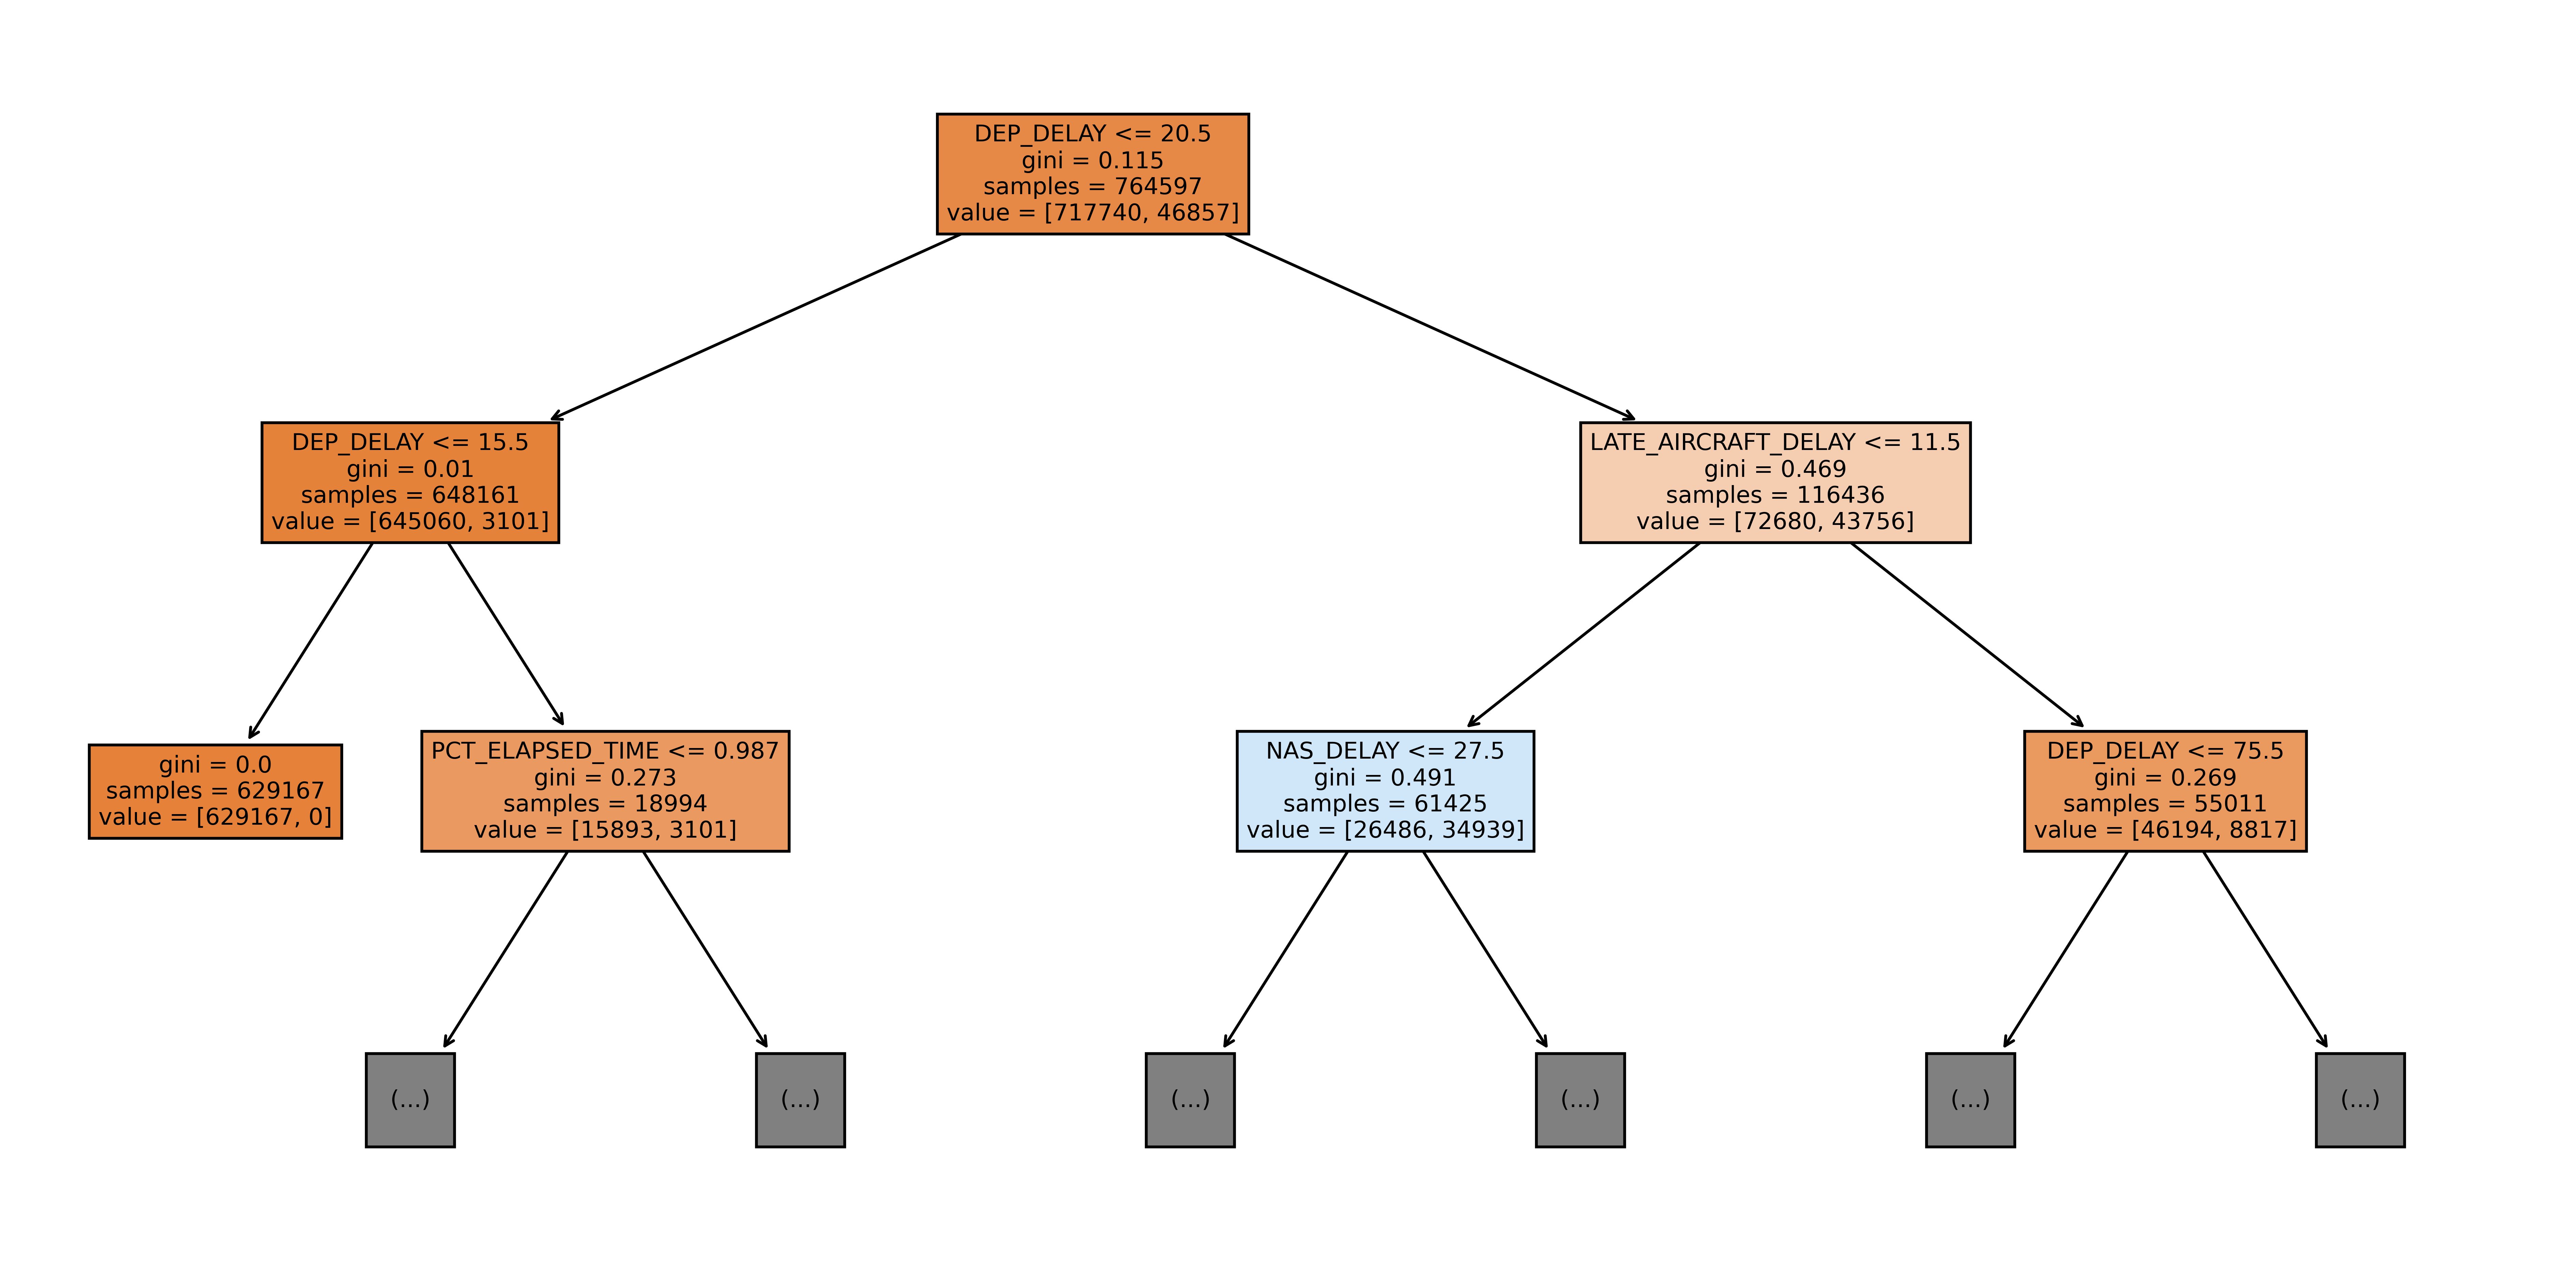

In [32]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [33]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

In [34]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'importance': class_models['decision_tree']['fitted'].feature_importances_}).\
            sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
2,DEP_DELAY,0.527482
16,LATE_AIRCRAFT_DELAY,0.199153
8,PCT_ELAPSED_TIME,0.105381
13,WEATHER_DELAY,0.101649
14,NAS_DELAY,0.062732
15,SECURITY_DELAY,0.001998
9,DISTANCE,0.001019
7,CRS_ELAPSED_TIME,0.000281
5,TAXI_OUT,0.000239
6,WHEELS_OFF,0.000035


### RuleFit

In [35]:
rulefit_df = reg_models['rulefit']['fitted'].get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0].sort_values(by="importance", ascending=False)
rulefit_df

,rule,type,coef,support,importance
142,WEATHER_DELAY <= 166.0 & LATE_AIRCRAFT_DELAY <...,rule,222.057048,0.001684,9.103439
74,LATE_AIRCRAFT_DELAY <= 333.5 & DEP_DELAY > 477.5,rule,175.787861,0.001122,5.885809
16,LATE_AIRCRAFT_DELAY,linear,-0.386265,1.000000,4.525916
2,DEP_DELAY,linear,0.163649,1.000000,4.281485
110,DEP_DELAY <= 1206.0,rule,-292.004580,0.999813,3.993324
...,...,...,...,...,...
36,DEP_DELAY <= 48.5 & DEP_DELAY <= 534.5,rule,-0.132322,0.921811,0.035524
154,DEP_DELAY <= 490.5 & LATE_AIRCRAFT_DELAY <= 22...,rule,0.133342,0.032735,0.023727
18,DEP_DOW,linear,0.009907,1.000000,0.019798
35,DEP_DELAY <= 415.0,rule,-0.214774,0.997942,0.009732


### Nearest Neighbors

#### k-Nearest Neighbors (kNN)

In [36]:
print(X_test.loc[721043,:])

CRS_DEP_TIME            655.000000
DEP_TIME               1055.000000
DEP_DELAY               240.000000
DEP_AFPH                 90.800000
DEP_RFPH                  0.890196
TAXI_OUT                 35.000000
WHEELS_OFF             1130.000000
CRS_ELAPSED_TIME        259.000000
PCT_ELAPSED_TIME          1.084942
DISTANCE               1660.000000
CRS_ARR_TIME            914.000000
ARR_AFPH                 40.434783
ARR_RFPH                  1.064073
WEATHER_DELAY             0.000000
NAS_DELAY                22.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY     221.000000
DEP_MONTH                10.000000
DEP_DOW                   4.000000
ORIGIN_HUB                1.000000
DEST_HUB                  0.000000
Name: 721043, dtype: float64


In [37]:
print(y_test_class[721043])

1


In [38]:
print(y_test_class[721043])

1


In [39]:
print(class_models['knn']['preds'][X_test.index.get_loc(721043)])

0


In [40]:
print(class_models['knn']['fitted'].kneighbors(X_test.loc[721043,:].values.reshape(1,21), 7))

(array([[143.3160128 , 173.90740076, 192.66705727, 211.57109221,
        243.57211853, 259.61593993, 259.77507391]]), array([[105172, 571912,  73409,  89450,  77474, 705972, 706911]]))


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [41]:
print(y_train_class.iloc[[105172, 571912,  73409,  89450,  77474, 705972, 706911]])

3813      0
229062    1
283316    0
385831    0
581905    1
726784    1
179364    0
Name: CARRIER_DELAY, dtype: int64


In [42]:
print(class_models['knn']['fitted'].effective_metric_)

euclidean


### Naïve Bayes

#### Gaussian Naïve Bayes

In [43]:
print(class_models['naive_bayes']['fitted'].class_prior_)

[0.93871674 0.06128326]


In [65]:
print(class_models['naive_bayes']['fitted'].var_)

[[2.50123026e+05 2.61324730e+05 9.21572605e+02 1.26123968e+03
  2.08339528e-01 9.58074414e+01 2.62606651e+05 6.30102550e+03
  1.13475535e-02 4.22470414e+05 2.75433641e+05 1.25314386e+03
  3.48655340e-01 1.11234714e+02 1.91877186e+02 2.80302201e+00
  5.06561612e+02 1.17346654e+01 3.99122491e+00 2.39015406e-01
  2.34996222e-01]
 [2.60629652e+05 2.96009867e+05 1.19307931e+04 1.14839167e+03
  1.99929921e+00 1.20404927e+02 3.08568277e+05 6.29066219e+03
  1.38936741e-02 4.10198938e+05 3.28574000e+05 1.09023147e+03
  3.08997044e+00 7.79140423e+01 1.56184090e+02 9.12112286e-01
  2.11279954e+03 1.02712368e+01 4.02943162e+00 1.77750796e-01
  2.50208354e-01]]


In [45]:
print(class_models['naive_bayes']['fitted'].theta_)

[[1.30740577e+03 1.31006271e+03 5.14196506e+00 5.45864877e+01
  1.09377996e+00 1.87120810e+01 1.33552258e+03 1.70734929e+02
  9.71131781e-01 1.01824369e+03 1.48438931e+03 5.39873058e+01
  1.09644787e+00 7.39971299e-01 2.85434558e+00 2.41814585e-02
  4.14674395e+00 6.55045281e+00 2.95035528e+00 6.06800513e-01
  6.24199571e-01]
 [1.41305545e+03 1.48087887e+03 8.45867640e+01 6.14731036e+01
  1.25429654e+00 1.99378321e+01 1.49409412e+03 1.72229998e+02
  9.83974416e-01 1.04363666e+03 1.54821862e+03 4.26486417e+01
  1.36373798e+00 4.50733082e-01 4.71991378e+00 2.11281132e-02
  1.40744819e+01 6.73367907e+00 3.04251232e+00 7.69575517e-01
  4.85391724e-01]]


## Discovering Newer Interpretable (Glass-box) Models

### Explainable Boosting Machine (EBM)

In [46]:
#Make new abbreviated versions of datasets
feature_samp = ['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',\
                'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
X_train_abbrev = X_train[feature_samp]
X_test_abbrev = X_test[feature_samp]

#For sampling among observations
sample_size = 0.1
sample_idx = np.random.choice(X_train.shape[0], math.ceil(X_train.shape[0]*sample_size), replace=False)

In [47]:
ebm_mdl = ExplainableBoostingClassifier()
ebm_mdl.fit(X_train_abbrev.iloc[sample_idx], y_train_class.iloc[sample_idx])

ExplainableBoostingClassifier(feature_names=['DEP_DELAY', 'LATE_AIRCRAFT_DELAY',
                                             'PCT_ELAPSED_TIME',
                                             'WEATHER_DELAY', 'NAS_DELAY',
                                             'SECURITY_DELAY', 'DISTANCE',
                                             'CRS_ELAPSED_TIME',
                                             'LATE_AIRCRAFT_DELAY x '
                                             'PCT_ELAPSED_TIME',
                                             'DEP_DELAY x NAS_DELAY',
                                             'LATE_AIRCRAFT_DELAY x NAS_DELAY',
                                             'DEP_DELAY x PCT_ELAPSED_TIME',
                                             'PCT_ELAPSED_TIME x NAS_DELAY',
                                             'NAS_DELAY x DISTANCE',
                                             'NA...
                                             'DEP_DELAY x LATE_AIRCRAFT_DELAY',

#### Global Interpretation

In [48]:
show(ebm_mdl.explain_global())

<!-- http://127.0.0.1:7001/6517678800/ -->

#### Local Interpretation

In [49]:
ebm_lcl = ebm_mdl.explain_local(X_test_abbrev.iloc[76:77],\
                                y_test_class[76:77], name='EBM')
show(ebm_lcl)

<!-- http://127.0.0.1:7001/6510276432/ -->

#### Performance

In [50]:
ebm_perf = ROC(ebm_mdl.predict_proba).\
                            explain_perf(X_test_abbrev,\
                                         y_test_class, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7001/6521540688/ -->

### GAMI-Net

In [52]:
meta_info = {col:{"type":"continuous"} for col in X_train_abbrev.columns}

X_train_abbrev2 = X_train_abbrev.copy()
X_test_abbrev2 = X_test_abbrev.copy()

for key in meta_info.keys():
    scaler = MinMaxScaler()
    X_train_abbrev2[[key]] = scaler.fit_transform(X_train_abbrev2[[key]])
    X_test_abbrev2[[key]] = scaler.transform(X_test_abbrev2[[key]])
    meta_info[key]["scaler"] = scaler
meta_info["CARRIER_DELAY"] = {"type":"target", "values":["no", "yes"]}

X_train_abbrev2 = X_train_abbrev2.to_numpy().astype(np.float32)
X_test_abbrev2 = X_test_abbrev2.to_numpy().astype(np.float32)
y_train_class2 = y_train_class.to_numpy().reshape(-1,1)
y_test_class2 = y_test_class.to_numpy().reshape(-1,1)

In [53]:
print(meta_info)

{'DEP_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'LATE_AIRCRAFT_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'PCT_ELAPSED_TIME': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'WEATHER_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'NAS_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'SECURITY_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'DISTANCE': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'CRS_ELAPSED_TIME': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'CARRIER_DELAY': {'type': 'target', 'values': ['no', 'yes']}}


In [55]:
gami_mdl = GAMINet(meta_info=meta_info, interact_num=8, task_type="Classification",\
                   main_effect_epochs=80, interaction_epochs=60, tuning_epochs=40,\
                   lr_bp=[0.0001] * 3, early_stop_thres=[10] * 3,\
                   interact_arch=[20] * 5, subnet_arch=[20] * 5,\
                   batch_size=200, activation_func=tf.nn.relu,\
                   heredity=True, loss_threshold=0.01, val_ratio=0.2,\
                   verbose=True, reg_clarity=1, random_state=rand)

gami_mdl.fit(X_train_abbrev2, y_train_class2)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.14208, val loss: 0.14073
Main effects training epoch: 2, train loss: 0.11131, val loss: 0.11011
Main effects training epoch: 3, train loss: 0.09226, val loss: 0.09160
Main effects training epoch: 4, train loss: 0.07860, val loss: 0.07808
Main effects training epoch: 5, train loss: 0.06832, val loss: 0.06789
Main effects training epoch: 6, train loss: 0.05315, val loss: 0.05264
Main effects training epoch: 7, train loss: 0.04359, val loss: 0.04336
Main effects training epoch: 8, train loss: 0.03931, val loss: 0.03926
Main effects training epoch: 9, train loss: 0.03723, val loss: 0.03719
Main effects training epoch: 10, train loss: 0.03350, val loss: 0.03336
Main effects training epoch: 11, train loss: 0.03143, val loss: 0.03108
Main effects training epoch: 12, train loss: 0.02982, val loss: 0.02941
Main effects training e

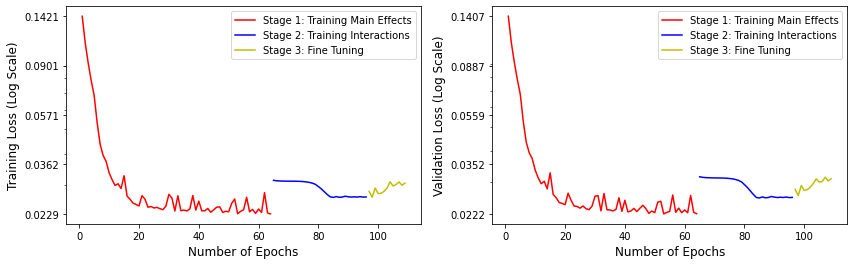

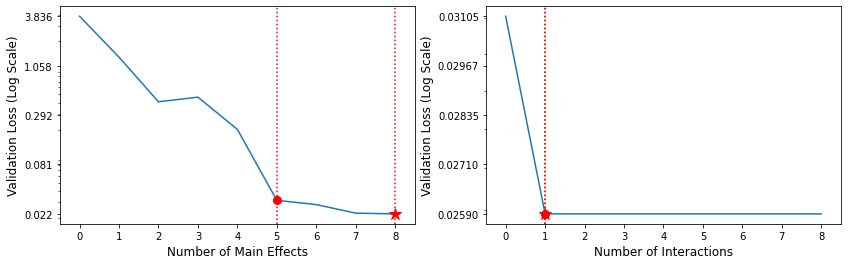

In [59]:
data_dict_logs = gami_mdl.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs)
plot_regularization(data_dict_logs)

#### Global Interpretation

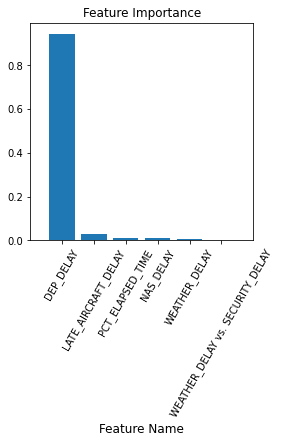

In [60]:
data_dict_global = gami_mdl.global_explain(save_dict=True)
feature_importance_visualize(data_dict_global)
plt.show()

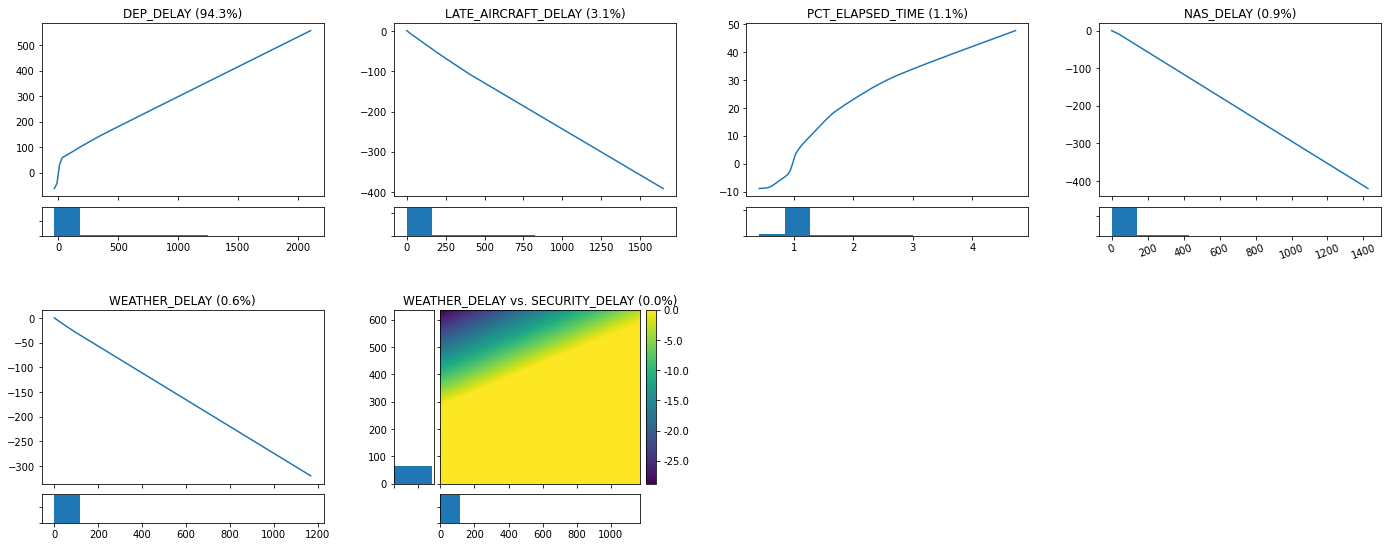

In [61]:
global_visualize_density(data_dict_global, name="flight_delay_global",
                         main_effect_num=8, interaction_num=1, cols_per_row=4, save_png=True, save_eps=True)

#### Local Interpretation

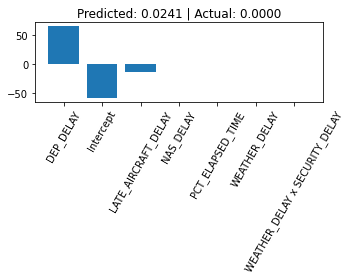

In [62]:
data_dict_local = gami_mdl.local_explain(X_test_abbrev2[[73]], y_test_class2[[73]], save_dict=False)
local_visualize(data_dict_local[0])
plt.tight_layout()
plt.show()

#### Performance

In [63]:
y_test_prob = gami_mdl.predict(X_test_abbrev2)
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
print('accuracy: %.3g, recall: %.3g, roc auc: %.3g, f1: %.3g, mcc: %.3g' %\
      (metrics.accuracy_score(y_test_class2, y_test_pred),\
       metrics.recall_score(y_test_class2, y_test_pred),\
       metrics.roc_auc_score(y_test_class2, y_test_prob),\
       metrics.f1_score(y_test_class2, y_test_pred),\
       metrics.matthews_corrcoef(y_test_class2, y_test_pred)))

accuracy: 0.991, recall: 0.934, roc auc: 0.998, f1: 0.924, mcc: 0.919
